In [1]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Instantiate a BigQuery client
client = bigquery.Client(project='logistics-customer-staging')
bq_storage = bigquery_storage.BigQueryReadClient()

g:\My Drive\APAC\venv_dh\lib\site-packages\google\auth\_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [19]:
# Define the global inputs
entity_id = "FP_TW"
test_keyword = "%Elasticity%"
analysis_start_date = "2023-06-01" # 2023-06-01 for TW and 2023-03-15 for TH

In [21]:
# Extract order data of these tests
orders_query = """
    WITH test_query AS (
        SELECT DISTINCT test_name
        FROM `fulfillment-dwh-production.cl.dps_experiment_setups`
        WHERE entity_id = "{entity_id_var}" AND test_name LIKE "{test_keyword_var}"
    )

    SELECT 
        -- Identifiers and supplementary fields     
        -- Date and time
        a.created_date AS created_date_utc,

        -- Location of order
        ent.segment AS region,
        a.entity_id,
        a.country_code,
        a.city_name,
        a.city_id,
        a.zone_name,
        a.zone_id,

        -- Order/customer identifiers and session data
        a.variant,
        a.experiment_id AS test_id,
        b.test_name,
        a.platform_order_code,
        a.scheme_id,
        a.vendor_price_scheme_type,	-- The assignment type of the scheme to the vendor during the time of the order, such as "Automatic", "Manual", "Campaign", and "Country Fallback".
        
        -- Vendor data and information on the delivery
        a.vendor_id,
        b.target_group AS target_group_bi,
        a.is_in_treatment,
        a.chain_id,
        a.chain_name,
        a.vertical_type,
        a.delivery_status,
        a.is_own_delivery,
        a.exchange_rate,

        -- Business KPIs (These are the components of profit)
        a.dps_delivery_fee_local,
        a.dps_travel_time_fee_local,
        a.dps_surge_fee_local,
        a.delivery_fee_local,
        IF(a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE, 0, a.delivery_fee_local) AS delivery_fee_local_incl_disc_and_vouchers,
        CASE WHEN ent.segment != "MENA" THEN a.commission_local ELSE COALESCE(mn.commission_amount_lc, a.commission_local) END AS commission_local,
        a.joker_vendor_fee_local,
        COALESCE(a.service_fee_local, 0) AS service_fee_local,
        a.mov_customer_fee_local AS sof_local,
        a.delivery_costs_local,
        CASE
            WHEN ent.segment IN ("Europe", "Asia") THEN COALESCE( -- Get the delivery fee data of Pandora countries from Pandata tables
                pd.delivery_fee_local, 
                -- In 99 pct of cases, we won"t need to use that fallback logic as pd.delivery_fee_local is reliable
                IF(a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE, 0, a.delivery_fee_local)
            )
            -- If the order comes from a non-Pandora country, use delivery_fee_local
            WHEN ent.segment NOT IN ("Europe", "Asia") THEN (CASE WHEN a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE THEN 0 ELSE a.delivery_fee_local END)
        END AS actual_df_paid_by_customer,
        a.gfv_local,
        a.gmv_local
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2` a
    LEFT JOIN `fulfillment-dwh-production.cl.dps_ab_test_orders_v2` b ON a.entity_id = b.entity_id AND a.order_id = b.order_id
    LEFT JOIN `fulfillment-dwh-production.pandata_curated.pd_orders` pd -- Contains info on the orders in Pandora countries
    ON TRUE 
        AND a.entity_id = pd.global_entity_id
        AND a.platform_order_code = pd.code 
        AND a.created_date = pd.created_date_utc -- There is no country_code field in this table
    LEFT JOIN `tlb-data-prod.data_platform.fct_billing` mn ON a.platform_order_code = CAST(mn.order_id AS STRING) AND a.entity_id IN ("TB_OM", "TB_IQ", "TB_AE", "TB_KW", "YS_TR", "TB_QA", "TB_JO", "HF_EG", "HS_SA", "TB_BH")
    INNER JOIN `fulfillment-dwh-production.curated_data_shared_coredata.global_entities` ent ON a.entity_id = ent.global_entity_id -- Get the region associated with every entity_id
    WHERE TRUE
        AND a.created_date >= DATE("{analysis_start_date_var}")
        AND b.test_name IN (SELECT * FROM test_query) -- Search for relevant tests
        AND a.is_sent -- Successful orders
        AND a.is_own_delivery -- OD orders only
        AND a.variant != "Original" -- Exclude orders from ASAs
        AND a.is_match_experiment_vertical -- Filter for sessions where the parent vertical of the vendor matches the parent vertical of the experiment	
    ;
""".format(entity_id_var=entity_id, test_keyword_var=test_keyword, analysis_start_date_var=analysis_start_date)

# Execute the orders query
df_orders = client.query(orders_query).result().to_dataframe(bqstorage_client=bq_storage, progress_bar_type="tqdm")

Downloading: 100%|██████████|


In [35]:
# Calculate the average DF per variant

# First, filter out orders from ASA
df_orders = df_orders[df_orders["variant"] != "Original"]

# Pick the list of functions for each KPI
list_agg_functions = ["mean", "nunique"]
agg_function_selection = {"delivery_fee_local": "mean", "dps_travel_time_fee_local": "mean", "platform_order_code": "nunique"}

# Perform the aggregation
df_agg_metrics = df_orders.\
    groupby(["entity_id", "test_name", "variant"])[["delivery_fee_local", "dps_travel_time_fee_local", "platform_order_code"]].\
    agg(agg_function_selection).\
    rename({"platform_order_code": "order_count"}, axis=1).\
    reset_index()

# Create a new data frame showing the values for the control group
df_control = df_orders[df_orders["variant"] == "Control"].\
    groupby(["entity_id", "test_name"])[["delivery_fee_local", "dps_travel_time_fee_local", "platform_order_code"]].\
    agg(agg_function_selection).\
    rename({"platform_order_code": "order_count"}, axis=1).\
    reset_index()

# Join df_agg_metrics with df_control
df_agg_metrics = pd.merge(left=df_agg_metrics, right=df_control, on=["entity_id", "test_name"], how="left", suffixes=["", "_control"])

# Change the data types of columns in df_agg_metrics
numerical_cols_df_agg_metrics = ["delivery_fee_local", "dps_travel_time_fee_local", "order_count", "delivery_fee_local_control", "dps_travel_time_fee_local_control", "order_count_control"]
df_agg_metrics[numerical_cols_df_agg_metrics] = df_agg_metrics[numerical_cols_df_agg_metrics].apply(lambda x: pd.to_numeric(x))

# Add new columns showing the elasticity calculations
df_agg_metrics = df_agg_metrics.assign(
    pct_diff_orders=round(df_agg_metrics["order_count"] / df_agg_metrics["order_count_control"] - 1, 4),
    pct_diff_tt_fee=round(df_agg_metrics["dps_travel_time_fee_local"] / df_agg_metrics["dps_travel_time_fee_local_control"] - 1, 4),
    pct_diff_df=round(df_agg_metrics["delivery_fee_local"] / df_agg_metrics["delivery_fee_local_control"] - 1, 4),
    elasticity=round((df_agg_metrics["order_count"] / df_agg_metrics["order_count_control"] - 1) / (df_agg_metrics["dps_travel_time_fee_local"]/df_agg_metrics["dps_travel_time_fee_local_control"] - 1), 4)
)

# Display the final data frame
df_agg_metrics.head()

,entity_id,test_name,variant,delivery_fee_local,dps_travel_time_fee_local,order_count,delivery_fee_local_control,dps_travel_time_fee_local_control,order_count_control,pct_diff_orders,pct_diff_tt_fee,pct_diff_df,elasticity
0,FP_TW,20230601_TW_R_Elasticity_Changhua,Control,18.537097,33.477303,55625,18.537097,33.477303,55625,0.0000,0.0000,0.0000,NaN
1,FP_TW,20230601_TW_R_Elasticity_Changhua,Variation1,16.021332,28.899009,55926,18.537097,33.477303,55625,0.0054,-0.1368,-0.1357,-0.0396
2,FP_TW,20230601_TW_R_Elasticity_Changhua,Variation2,21.078876,38.802548,53299,18.537097,33.477303,55625,-0.0418,0.1591,0.1371,-0.2629
3,FP_TW,20230601_TW_R_Elasticity_Changhua,Variation3,22.278681,43.788600,52422,18.537097,33.477303,55625,-0.0576,0.3080,0.2018,-0.1869
4,FP_TW,20230601_TW_R_Elasticity_Chiayi,Control,17.740921,36.152469,35850,17.740921,36.152469,35850,0.0000,0.0000,0.0000,NaN


In [36]:
# Extract sessions data of these tests
sessions_query = """
  WITH test_query AS (
    SELECT DISTINCT test_name
    FROM `fulfillment-dwh-production.cl.dps_experiment_setups`
    WHERE entity_id = "{entity_id_var}" AND test_name LIKE "{test_keyword_var}"
  )

  SELECT
    entity_id,
    created_date,
    created_at,
    test_name,
    ga_session_id,
    variant,
    test_zone_id AS zone_id,
    perseus_client_id,
    vendor_code,
    target_group,
    treatment,
    shop_list_no,
    shop_menu_no,
    checkout_no,
    transaction_no,
  FROM `fulfillment-dwh-production.cl.dps_cvr_ab_tests_treatment`
  WHERE TRUE
    AND created_date >= "{analysis_start_date_var}"
    AND test_name IN (SELECT * FROM test_query) -- Search for relevant tests
    AND vertical_parent_in_test = TRUE -- Filter for sessions where the parent vertical of the vendor matches the parent vertical of the experiment
    AND variant != "Original" -- Filter out sessions with variant = "Original"
""".format(entity_id_var=entity_id, test_keyword_var=test_keyword, analysis_start_date_var=analysis_start_date)

# Execute the sessions query
df_sessions = client.query(sessions_query).result().to_dataframe(bqstorage_client=bq_storage, progress_bar_type="tqdm")

Downloading: 100%|██████████|


In [38]:
def count_unique_non_null(x):
    return x.nunique(dropna=True)

# Perform the aggregation
df_agg_cvr = df_sessions.\
    groupby(["entity_id", "test_name", "variant"])[["ga_session_id", "shop_list_no", "shop_menu_no", "checkout_no", "transaction_no"]].\
    agg(count_unique_non_null).\
    reset_index()

# Add new columns calculating CVR
df_agg_cvr["cvr"] = round(df_agg_cvr["transaction_no"] / df_agg_cvr["ga_session_id"], 4)
df_agg_cvr["cvr3"] = round(df_agg_cvr["transaction_no"] / df_agg_cvr["shop_menu_no"], 4)

# Create a new data frame showing the values for the control group
df_agg_cvr = pd.merge(
    left=df_agg_cvr,
    right=df_agg_cvr[df_agg_cvr["variant"] == "Control"][["entity_id", "test_name", "cvr", "cvr3"]],
    on=["entity_id", "test_name"],
    how="left",
    suffixes=["", "_control"]
)

# Calculate the CVR % difference between variation and control
df_agg_cvr = df_agg_cvr.assign(
    pct_diff_cvr=round(df_agg_cvr["cvr"] / df_agg_cvr["cvr_control"] - 1, 4),
    pct_diff_cvr3=round(df_agg_cvr["cvr3"] / df_agg_cvr["cvr3_control"] - 1, 4),
)
df_agg_cvr.head()

,entity_id,test_name,variant,ga_session_id,shop_list_no,shop_menu_no,checkout_no,transaction_no,cvr,cvr3,cvr_control,cvr3_control,pct_diff_cvr,pct_diff_cvr3
0,FP_TW,20230601_TW_R_Elasticity_Changhua,Control,108685,77663,102770,54118,51403,0.4730,0.5002,0.4730,0.5002,0.0000,0.0000
1,FP_TW,20230601_TW_R_Elasticity_Changhua,Variation1,108351,77137,102532,54324,51620,0.4764,0.5035,0.4730,0.5002,0.0072,0.0066
2,FP_TW,20230601_TW_R_Elasticity_Changhua,Variation2,106415,76951,100155,51953,49222,0.4625,0.4915,0.4730,0.5002,-0.0222,-0.0174
3,FP_TW,20230601_TW_R_Elasticity_Changhua,Variation3,104684,74417,98737,51354,48718,0.4654,0.4934,0.4730,0.5002,-0.0161,-0.0136
4,FP_TW,20230601_TW_R_Elasticity_Chiayi,Control,67739,46627,64046,34606,32967,0.4867,0.5147,0.4867,0.5147,0.0000,0.0000
5,FP_TW,20230601_TW_R_Elasticity_Chiayi,Variation1,65510,44895,61984,33795,32210,0.4917,0.5197,0.4867,0.5147,0.0103,0.0097
6,FP_TW,20230601_TW_R_Elasticity_Chiayi,Variation2,64751,44355,61285,32553,31089,0.4801,0.5073,0.4867,0.5147,-0.0136,-0.0144
7,FP_TW,20230601_TW_R_Elasticity_Chiayi,Variation3,65861,45878,62252,33307,31673,0.4809,0.5088,0.4867,0.5147,-0.0119,-0.0115
8,FP_TW,20230601_TW_R_Elasticity_Hualien,Control,46020,31041,43969,25532,24522,0.5329,0.5577,0.5329,0.5577,0.0000,0.0000
9,FP_TW,20230601_TW_R_Elasticity_Hualien,Variation1,47219,31344,45006,26161,25014,0.5297,0.5558,0.5329,0.5577,-0.0060,-0.0034


In [39]:
# Join df_agg_cvr to df_agg_metrics
df_agg_metrics = pd.merge(left=df_agg_metrics, right=df_agg_cvr[["entity_id", "test_name", "variant", "cvr", "pct_diff_cvr", "cvr3", "pct_diff_cvr3"]], on=["entity_id", "test_name", "variant"], how='left')
df_agg_metrics.head()

,entity_id,test_name,variant,delivery_fee_local,dps_travel_time_fee_local,order_count,delivery_fee_local_control,dps_travel_time_fee_local_control,order_count_control,pct_diff_orders,pct_diff_tt_fee,pct_diff_df,elasticity,cvr,pct_diff_cvr,cvr3,pct_diff_cvr3
0,FP_TW,20230601_TW_R_Elasticity_Changhua,Control,18.537097,33.477303,55625,18.537097,33.477303,55625,0.0000,0.0000,0.0000,NaN,0.4730,0.0000,0.5002,0.0000
1,FP_TW,20230601_TW_R_Elasticity_Changhua,Variation1,16.021332,28.899009,55926,18.537097,33.477303,55625,0.0054,-0.1368,-0.1357,-0.0396,0.4764,0.0072,0.5035,0.0066
2,FP_TW,20230601_TW_R_Elasticity_Changhua,Variation2,21.078876,38.802548,53299,18.537097,33.477303,55625,-0.0418,0.1591,0.1371,-0.2629,0.4625,-0.0222,0.4915,-0.0174
3,FP_TW,20230601_TW_R_Elasticity_Changhua,Variation3,22.278681,43.788600,52422,18.537097,33.477303,55625,-0.0576,0.3080,0.2018,-0.1869,0.4654,-0.0161,0.4934,-0.0136
4,FP_TW,20230601_TW_R_Elasticity_Chiayi,Control,17.740921,36.152469,35850,17.740921,36.152469,35850,0.0000,0.0000,0.0000,NaN,0.4867,0.0000,0.5147,0.0000
5,FP_TW,20230601_TW_R_Elasticity_Chiayi,Variation1,16.181389,31.483116,35151,17.740921,36.152469,35850,-0.0195,-0.1292,-0.0879,0.1510,0.4917,0.0103,0.5197,0.0097
6,FP_TW,20230601_TW_R_Elasticity_Chiayi,Variation2,20.164113,41.439100,33678,17.740921,36.152469,35850,-0.0606,0.1462,0.1366,-0.4143,0.4801,-0.0136,0.5073,-0.0144
7,FP_TW,20230601_TW_R_Elasticity_Chiayi,Variation3,21.030340,46.304333,34344,17.740921,36.152469,35850,-0.0420,0.2808,0.1854,-0.1496,0.4809,-0.0119,0.5088,-0.0115
8,FP_TW,20230601_TW_R_Elasticity_Hualien,Control,14.844154,26.994358,26584,14.844154,26.994358,26584,0.0000,0.0000,0.0000,NaN,0.5329,0.0000,0.5577,0.0000
9,FP_TW,20230601_TW_R_Elasticity_Hualien,Variation1,12.560797,22.491419,27386,14.844154,26.994358,26584,0.0302,-0.1668,-0.1538,-0.1809,0.5297,-0.0060,0.5558,-0.0034


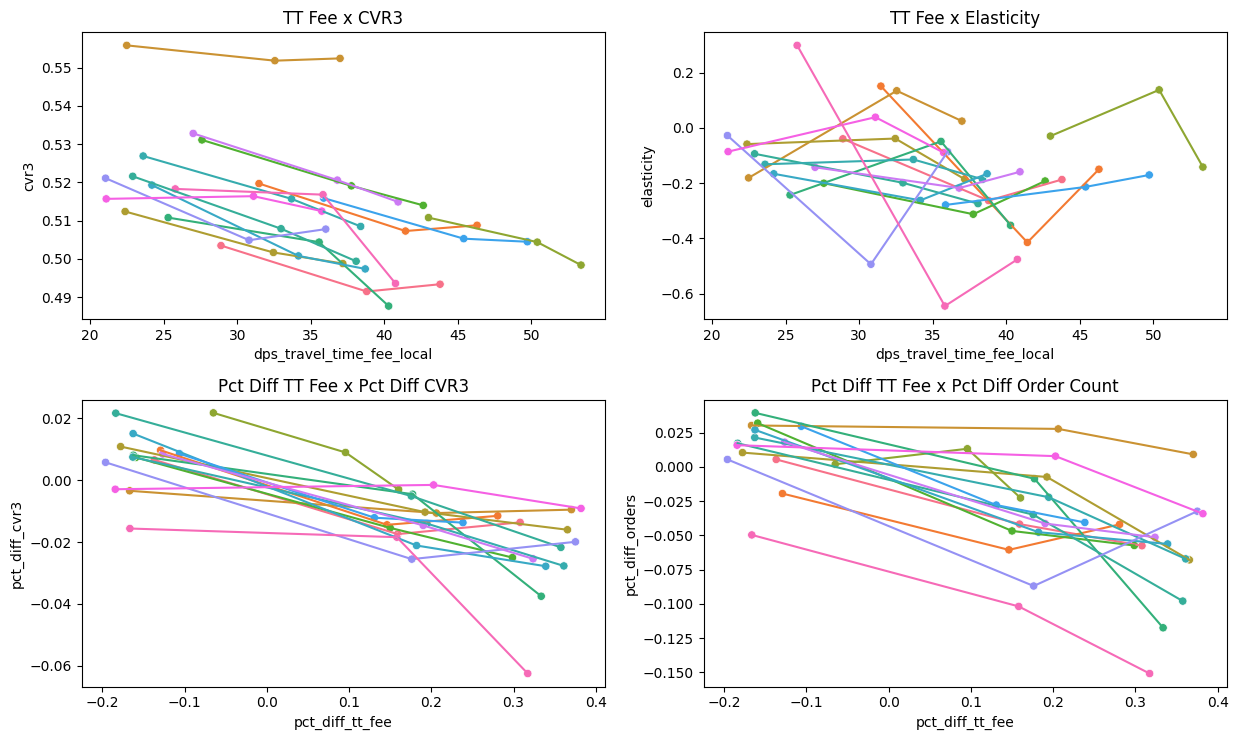

In [46]:
# Create the data frame for plotting
# Include this condition if you wish to exclude the outlier tests --> ~(df_agg_metrics["test_name"].isin(["20230601_TW_R_Elasticity_Penghu", "20230601_TW_R_Elasticity_Kinmen"]))
df_plot = df_agg_metrics[(df_agg_metrics["variant"] != "Control")]\
    [["entity_id", "test_name", "variant", "pct_diff_tt_fee", "pct_diff_orders", "pct_diff_cvr3", "elasticity", "dps_travel_time_fee_local", "order_count", "cvr3"]]

# Create some EDA plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12.5, 7.5))

# 1st chart: TT fee x CVR
sns.scatterplot(data=df_plot, x="dps_travel_time_fee_local", y="cvr3", hue="test_name", ax=axes[0,0])
sns.lineplot(data=df_plot, x="dps_travel_time_fee_local", y="cvr3", hue="test_name", ax=axes[0,0])
axes[0,0].set_title("TT Fee x CVR3")

# 2nd chart: TT fee x elasticity
sns.scatterplot(data=df_plot, x="dps_travel_time_fee_local", y="elasticity", hue="test_name", ax=axes[0,1])
sns.lineplot(data=df_plot, x="dps_travel_time_fee_local", y="elasticity", hue="test_name", ax=axes[0,1])
axes[0,1].set_title("TT Fee x Elasticity")

# 3rd chart: Pct Diff TT fee x Pct Diff CVR
sns.scatterplot(data=df_plot, x="pct_diff_tt_fee", y="pct_diff_cvr3", hue="test_name", ax=axes[1,0])
sns.lineplot(data=df_plot, x="pct_diff_tt_fee", y="pct_diff_cvr3", hue="test_name", ax=axes[1,0])
axes[1,0].set_title("Pct Diff TT Fee x Pct Diff CVR3")

# 4th chart: pct_diff_tt_fee x pct_diff_orders
sns.scatterplot(data=df_plot, x="pct_diff_tt_fee", y="pct_diff_orders", hue="test_name", ax=axes[1,1])
sns.lineplot(data=df_plot, x="pct_diff_tt_fee", y="pct_diff_orders", hue="test_name", ax=axes[1,1])
axes[1,1].set_title("Pct Diff TT Fee x Pct Diff Order Count")

# Remove the legends
axes[0,0].get_legend().remove()
axes[0,1].get_legend().remove()
axes[1,0].get_legend().remove()
axes[1,1].get_legend().remove()

# Right layout
plt.tight_layout()